<a href="https://colab.research.google.com/github/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching/blob/main/evaluations/moon_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tayfununal/Uniform-Autoencoder-with-Latent-Flow-Matching.git

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os

print(os.getcwd())

%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/models/moon_model.ipynb
%run /content/Uniform-Autoencoder-with-Latent-Flow-Matching/datasets/moon_dataset.ipynb

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [3]:
# Custom Transform
class NoiseTransform:
    """Add some noise."""

    def __init__(self, split_ratio=0.001, dim=2):

        self.split_ratio = split_ratio
        self.dim = dim

    def __call__(self, x):
      return x + self.split_ratio * np.random.randn(self.dim,)

In [4]:
# Hyper-Parameters & Settings

dataset_size = 1000
batch_size = 500
lr = 0.003

epochs = 1000
max_patience = 1000

split_ratio = 0.001

In [5]:
# Dataset
train_dataset = MoonDataset(mode='train', n_samples=dataset_size, transform=NoiseTransform(split_ratio))
val_dataset = MoonDataset(mode='val', n_samples=dataset_size, transform=NoiseTransform(split_ratio))
test_dataset = MoonDataset(mode='test', n_samples=dataset_size)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Evaluation

In [6]:
# Create the "results" folder
os.makedirs("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results", exist_ok=True)

name = '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/UAE_Moon'
model_eval = torch.load(name + '.model', weights_only=False)
model_eval.eval()

To_Uniform(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): SiLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): SiLU()
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
    (7): Sigmoid()
  )
)

# MSE on Test Set

In [7]:
X_test, y_test = next(iter(test_loader))

# Feed the test data into the model
with torch.no_grad():
    z, x_hat = model_eval(X_test)

# MSE Loss
mse_loss = nn.MSELoss()

# Compute the average MSE
mse = mse_loss(x_hat, X_test)

print("Test MSE:", mse.item())

# Create the "results" folder
os.makedirs("results", exist_ok=True)

# Write to file
file_path = "/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/test_mse.txt"
with open(file_path, "w") as f:
    f.write(f"Test MSE: {mse.item()}\n")

print(f"Test MSE results have been saved to the '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon' directory: {file_path}")

Test MSE: 0.0003967524680774659
Test MSE results have been saved to the '/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon' directory: /content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/test_mse.txt


In [8]:
from torchsummary import summary
summary(model_eval, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             192
              SiLU-2                   [-1, 64]               0
       BatchNorm1d-3                   [-1, 64]             128
            Linear-4                   [-1, 64]           4,160
              SiLU-5                   [-1, 64]               0
       BatchNorm1d-6                   [-1, 64]             128
            Linear-7                   [-1, 64]           4,160
              SiLU-8                   [-1, 64]               0
       BatchNorm1d-9                   [-1, 64]             128
           Linear-10                    [-1, 1]              65
          Sigmoid-11                    [-1, 1]               0
           Linear-12                   [-1, 64]             128
             SiLU-13                   [-1, 64]               0
           Linear-14                   

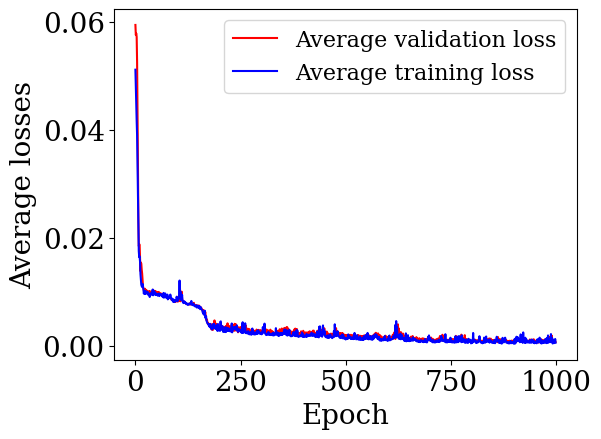

In [9]:
# Load the losses
losses = np.loadtxt("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Create a plot
plt.plot(val_losses, label="Average validation loss", c="red")
plt.plot(train_losses, label="Average training loss", c="blue")

plt.xlabel("Epoch")
plt.ylabel("Average losses")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/average_losses_per_epoch.pdf")
plt.show()

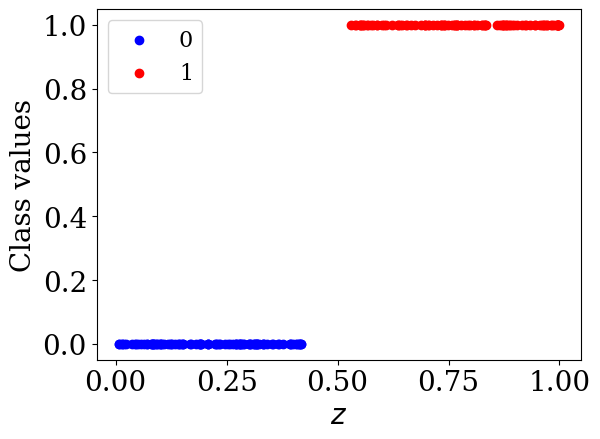

In [10]:
X_test, y_test = next(iter(test_loader))

z, x_hat = model_eval(X_test[:])

# Class 0
plt.scatter(z.detach().numpy()[y_test.detach().numpy()==0],
            y_test.detach().numpy()[y_test.detach().numpy()==0],
            color='blue', label='0', alpha=1)

# Class 1
plt.scatter(z.detach().numpy()[y_test.detach().numpy()==1],
            y_test.detach().numpy()[y_test.detach().numpy()==1],
            color='red', label='1', alpha=1)

# Legend
plt.legend(loc='upper left')
plt.ylabel('Class values')
plt.xlabel('$z$')
plt.legend(loc='upper left', fontsize=16)

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/moon_test_data_latent.pdf")
plt.show()

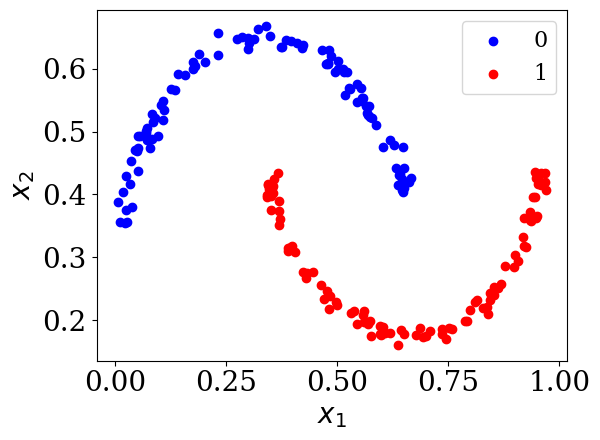

In [11]:
# Class 0
plt.scatter(x_hat.detach().numpy()[y_test==0, 0],
            x_hat.detach().numpy()[y_test==0, 1], color='blue', label='0', alpha=1)

# Class 1
plt.scatter(x_hat.detach().numpy()[y_test==1, 0],
            x_hat.detach().numpy()[y_test==1, 1], color='red', label='1', alpha=1)

# Legend
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/moon_test_data_prod.pdf")
plt.show()

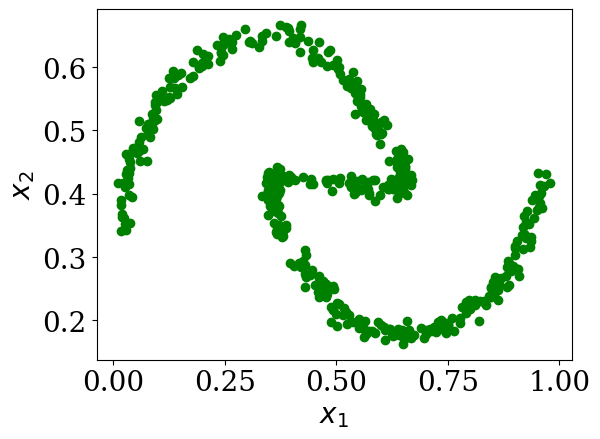

In [12]:
uniform_dist = torch.distributions.uniform.Uniform(low= torch.zeros((1,)), high=torch.ones((1,)))
new_data = model_eval.decode(uniform_dist.sample((500,)))

plt.scatter(new_data[:,0].cpu().detach().numpy(), new_data[:,1].cpu().detach().numpy(), c='green', alpha=1)


plt.ylabel('$x_2$')
plt.xlabel('$x_1$')

plt.tight_layout()
plt.savefig("/content/Uniform-Autoencoder-with-Latent-Flow-Matching/results/moon/uniform_to_moon.pdf")
plt.show()